In [1]:
%%capture
%run 02_FeatEng.ipynb

In [2]:
from fbprophet import Prophet
from  sklearn.metrics import mean_squared_error  as skl_mse

Importing plotly failed. Interactive plots will not work.


In [3]:
import mle.tsa as mle_tsa

In [50]:
OUTPATH = 'data/out/'
OUTFILE = 'cons_gna95_fbprophet.xlsx'

# Split Data

In [5]:
endog_GNA95_train = data_train.loc['2010':, ['cons_GNA95']].copy()
endog_GNA95_train['y'] = np.log(endog_GNA95_train['cons_GNA95'])
endog_GNA95_train['ds'] = endog_GNA95_train.index.strftime("%Y-%m-%d")

In [6]:
endog_GNA95_test = data_test[['cons_GNA95']].copy()
endog_GNA95_test['y'] = np.log(endog_GNA95_test['cons_GNA95'])
endog_GNA95_test['ds'] = endog_GNA95_test.index.strftime("%Y-%m-%d")

# Model Building
* In prophet multistep forecasting is done by default

In [7]:
mod_prophet = Prophet()
res_prophet = mod_prophet.fit(df=endog_GNA95_train[['ds', 'y']])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
future = mod_prophet.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
117,2019-09-30
118,2019-10-31
119,2019-11-30
120,2019-12-31
121,2020-01-31


In [9]:
forecast = res_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
117,2019-09-30,12.963770,12.935352,12.994544
118,2019-10-31,12.834890,12.803459,12.867657
119,2019-11-30,12.966279,12.932910,13.001305
120,2019-12-31,12.815277,12.778360,12.849395
121,2020-01-31,12.860141,12.820793,12.899992


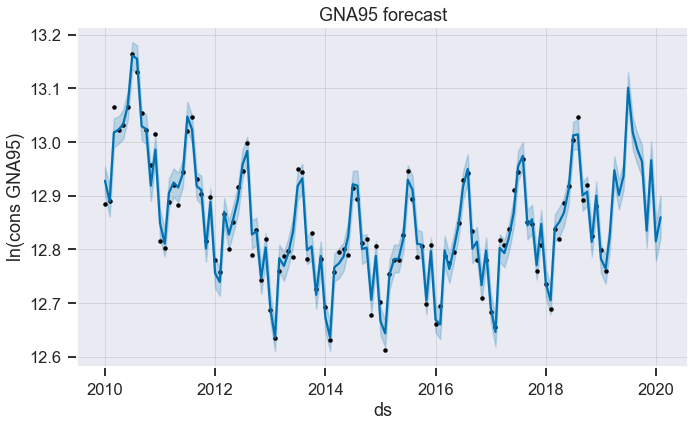

In [10]:
fig1 = res_prophet.plot(forecast)
plt.title('GNA95 forecast')
plt.ylabel(r'ln(cons GNA95)')
plt.show()

## Prediction

In [47]:
rename_fbprophet = {'yhat_lower': 'lower p_cons_GNA95', 'yhat_upper': 'upper p_cons_GNA95', 'yhat': 'p_cons_GNA95'}

p_gna95_train = np.exp(forecast[['yhat_lower', 'yhat_upper', 'yhat']]).rename(columns=rename_fbprophet)

p_gna95_train.index = forecast['ds'].dt.date
p_gna95_train.index.name = 'Date' 

p_gna95_train['cons_GNA95'] = endog_GNA95_train['cons_GNA95']

p_gna95_train['model'] = 'fbprophet'
p_gna95_train['split'] = 'train'

# Forecasting

## Multistep Forecasting

In [12]:
mstep_forecast_test = forecast[-12:]
mstep_forecast_test.index = pd.to_datetime(mstep_forecast_test['ds'])
mstep_forecast_test = mstep_forecast_test.resample('MS').first()
mstep_forecast_test = np.exp(mstep_forecast_test[['yhat_lower', 'yhat_upper', 'yhat']]).rename(columns=rename_fbprophet)

mstep_forecast_test.tail()

,lower p_cons_GNA95,upper p_cons_GNA95,p_cons_GNA95
ds,,,
2019-09-01,414716.963704,440005.975504,426671.643812
2019-10-01,363472.416685,387571.892531,375078.358813
2019-11-01,413705.596758,442991.052863,427743.586760
2019-12-01,354463.238396,380558.336887,367793.482505
2020-01-01,369827.764292,400308.908840,384669.893547


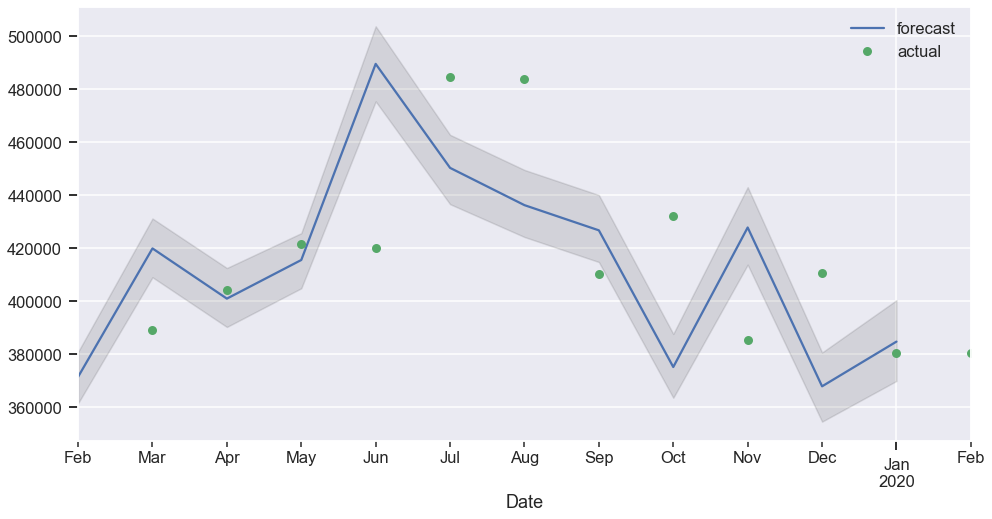

In [15]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)

mstep_forecast_test.plot(y='p_cons_GNA95', label='forecast', ax=ax)
ax.fill_between(x=mstep_forecast_test.index, y1=mstep_forecast_test['upper p_cons_GNA95'], y2=mstep_forecast_test['lower p_cons_GNA95'],  color='k', alpha=0.1)
endog_GNA95_test['cons_GNA95'].plot(ax=ax, y='cons_GNA95', style='o', label='actual')
plt.legend()
plt.show()

In [14]:
mle_tsa.compute_ape(endog_GNA95_test['cons_GNA95'], mstep_forecast_test['p_cons_GNA95']).mean()

0.07566971353981763

# Single Step Forecasting

In [16]:
forecast_mods, forecast_test = mle_tsa.prophet_endog_forecast(train_endog=endog_GNA95_train, test_endog=endog_GNA95_test)

C:\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [39]:
p_gna95_test = np.exp(forecast_test[['yhat_lower', 'yhat_upper', 'yhat']]).rename(columns=rename_fbprophet)

p_gna95_test.index = forecast_test['ds'].dt.date
p_gna95_test.index.name = 'Date'

p_gna95_test['cons_GNA95'] = endog_GNA95_test['cons_GNA95'].copy()

p_gna95_test['model'] = 'fbprophet'
p_gna95_test['split'] = 'test'

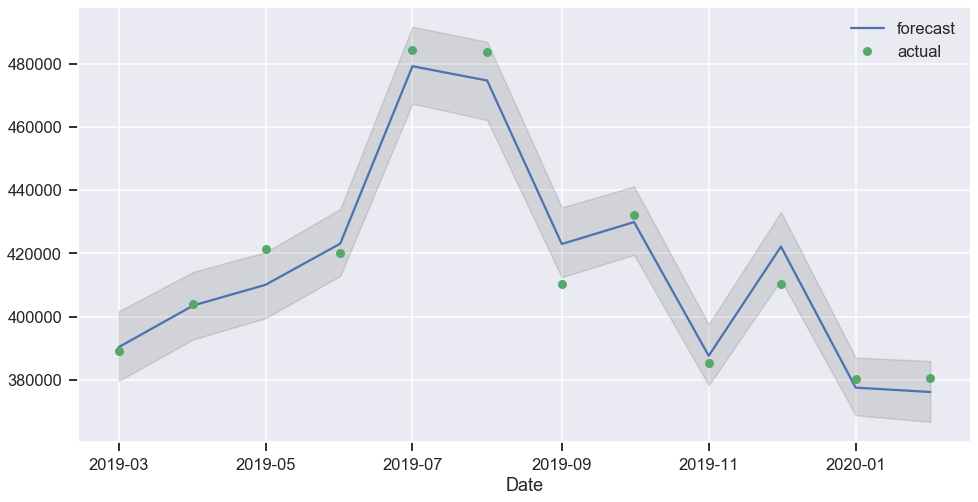

In [41]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)

p_gna95_test.plot(y='p_cons_GNA95', label='forecast', ax=ax)
ax.fill_between(x=p_gna95_test.index, y1=p_gna95_test['upper p_cons_GNA95'], y2=p_gna95_test['lower p_cons_GNA95'],  color='k', alpha=0.1)
p_gna95_test.plot(ax=ax, y='cons_GNA95', style='o', label='actual')
plt.legend()
plt.show()

# Model Assessment

In [42]:
skl_mse(np.log(endog_GNA95_test['cons_GNA95']/1e3), forecast_test['yhat'])**0.5

6.90724314817098

In [43]:
mle_tsa.compute_ape(p_gna95_test['cons_GNA95'], p_gna95_test['p_cons_GNA95']).mean()

0.013086659291806073

In [51]:
select_cols = ['model', 'split', 'cons_GNA95', 'p_cons_GNA95', 'lower p_cons_GNA95', 'upper p_cons_GNA95']

pd.concat([p_gna95_train, p_gna95_test], axis=0)[select_cols].to_excel(OUTPATH + OUTFILE, index_label='Date')